In [1]:
# 환경 설정
from mlwpy import *
diabetes = datasets.load_diabetes()
%matplotlib inline

In [2]:
N = 20
ftr = np.linspace(-10, 10, num=N)                # 특성
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N) # 타깃 = 함수(특성)

(train_ftr, test_ftr,
 train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)

display(pd.DataFrame({"ftr":train_ftr, 
                      "tgt":train_tgt}).T)

,0,1,2,3,4,5,6,7,8,9
ftr,-1.5789,-6.8421,-3.6842,1.5789,-7.8947,3.6842,7.8947,4.7368,5.7895,-0.5263
tgt,2.3906,91.0234,22.3791,3.8658,122.5817,22.9962,121.7528,40.6026,62.7696,-1.6137


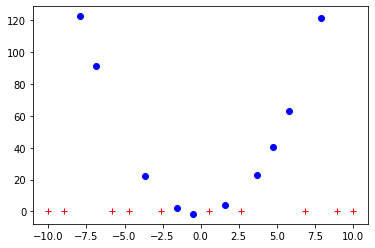

In [3]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr,  np.zeros_like(test_ftr), 'r+');

In [4]:
# 노트: sklearn은 2차원 입력(테이블)을 정말 좋아합니다.
# 따라서 데이터의 형태를 재구성(reshape)합니다.
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1,1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1,1))
sk_preds[:3]

array([53.218 , 41.4552, 56.8374])

In [5]:
# 1차 다항식(직선)을 적합-예측-평가합니다.
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

[53.218  41.4552 56.8374]


In [6]:
# 예측값이 모두 일치하는지 확인합니다.
print("all close?", np.allclose(sk_preds, preds_one))

# sklearn을 이용해서 평가합니다.
mse = metrics.mean_squared_error
print("RMSE:", np.sqrt(mse(test_tgt, preds_one)))

all close? True
RMSE: 86.69151817350722


In [7]:
# 2차 다항식(포물선)을 적합-예측-평가합니다.
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_two)))

RMSE: 1.2765992188881117


In [8]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_three)))

RMSE: 317.3634424235501


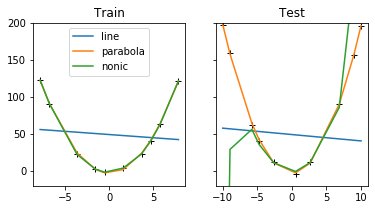

In [9]:
fig, axes = plt.subplots(1,2, figsize=(6,3), sharey=True)

labels = ['line', 'parabola', 'nonic']
models = [model_one, model_two, model_three]
train = (train_ftr, train_tgt)
test  = (test_ftr, test_tgt)

for ax, (ftr, tgt) in zip(axes, [train, test]):
    ax.plot(ftr, tgt, 'k+')
    for m, lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)

axes[1].set_ylim(-20, 200)
axes[0].set_title("Train")
axes[1].set_title("Test");
axes[0].legend(loc='upper center');

In [10]:
results = []
for complexity in [1,2,6,9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error = np.sqrt(mse(test_tgt, model(test_ftr)))
    results.append((complexity, train_error, test_error))
   
columns = ["Complexity", "Train Error", "Test Error"]
results_df = pd.DataFrame.from_records(results, 
                                       columns=columns,
                                       index="Complexity")

results_df

,Train Error,Test Error
Complexity,,
1,45.4951,86.6915
2,1.0828,1.2766
6,0.2819,6.1417
9,0.0000,317.3634


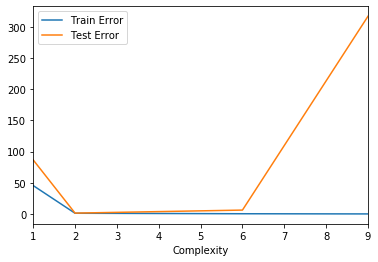

In [11]:
results_df.plot();

In [12]:
def training_loss(loss, model, training_data):
    '모델과 전체 학습 데이터를 이용한 학습 손실의 총 합'
    return sum(loss(model.predict(x.reshape(1,-1)), y) 
                                 for x,y in training_data)
def squared_error(prediction, actual):
    '개별 사례에 대한 오차 제곱'
    return (prediction-actual)**2

# 아래와 같이 사용합니다:
# my_training_loss = training_loss(squared_error, model, training_data)	

In [13]:
knn   = neighbors.KNeighborsRegressor(n_neighbors=3)
fit   = knn.fit(diabetes.data, diabetes.target)

training_data = zip(diabetes.data, diabetes.target)

my_training_loss = training_loss(squared_error, 
                                 knn, 
                                 training_data)
print(my_training_loss)

[863792.3333]


In [14]:
mse = metrics.mean_squared_error(diabetes.target,
                                 knn.predict(diabetes.data))
print(mse*len(diabetes.data))

863792.3333333333


In [15]:
def complexity(model):
    return model.complexity

def cost(model, training_data, loss, _lambda):
    return training_loss(m,D) + _lambda * complexity(m) 

In [16]:
# 데이터, 모델, 적합 & 교차 검증
model = neighbors.KNeighborsRegressor(10)
skms.cross_val_score(model, 
                     diabetes.data, 
                     diabetes.target,
                     cv=5,
                     scoring='neg_mean_squared_error')
# 노트:
# cross_val_score의 기본 설정은 다음과 같습니다.
# cv=3 fold, 섞지 않음, 분류 모델인 경우 층화 추출 수행
# model.score 기본 설정 (회귀 모델: r2, 분류 모델: accuracy) 

array([-3206.7542, -3426.4313, -3587.9422, -3039.4944, -3282.6016])

In [17]:
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
skms.cross_val_score(model, iris.data, iris.target, cv=5)

array([0.9667, 1.    , 1.    , 0.9333, 1.    ])

In [18]:
# 층화 추출을 사용하지 않습니다.
pet = np.array(['cat', 'dog', 'cat', 
                'dog', 'dog', 'dog'])
list_folds = list(skms.KFold(2).split(pet))
training_idxs = np.array(list_folds)[:,0,:]

print(pet[training_idxs])

[['dog' 'dog' 'dog']
 ['cat' 'dog' 'cat']]


In [19]:
# 층화 추출을 사용합니다.
# 노트: 보통 작동 방식이 표면적으로 드러나지 않습니다.
# StratifiedKFold로 사람이 읽을 수 있는 결과를 출력하게 하려면
# 약간의 트릭이 필요합니다. 
pet = np.array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog'])
idxs = np.array(list(skms.StratifiedKFold(2)
                         .split(np.ones_like(pet), pet)))
training_idxs = idxs[:,0,:]
print(pet[training_idxs])

[['cat' 'dog' 'dog']
 ['cat' 'dog' 'dog']]


In [20]:
# 비 층화 추출 CV를 실행합니다.
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
non_strat_kf = skms.KFold(5)
skms.cross_val_score(model, 
                     iris.data, 
                     iris.target, 
                     cv=non_strat_kf)

array([1.    , 1.    , 0.8667, 0.9667, 0.7667])

In [21]:
# from mlwpy import *로 인해서 가려진 
# 라이브러리 import 구문은 아래와 같습니다.
# from sklearn import (datasets, neighbors,
#                      model_selection as skms,
#                      linear_model, metrics)
# 자세한 내용은 부록 A를 참조하세요.

linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

scores = []
for r in range(10):
    tts = skms.train_test_split(diabetes.data, 
                                diabetes.target, 
                                test_size=.25)
    
    (diabetes_train_ftrs, diabetes_test_ftrs, 
     diabetes_train_tgt,  diabetes_test_tgt) = tts
    
    
    fit   = linreg.fit(diabetes_train_ftrs, diabetes_train_tgt)
    preds = fit.predict(diabetes_test_ftrs)

    score = metrics.mean_squared_error(diabetes_test_tgt, preds)
    scores.append(score)

scores = pd.Series(np.sqrt(sorted(scores)))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'
display(df.T)

Repeat,0,1,2,3,4,5,6,7,8,9
RMSE,49.0032,50.1912,51.9735,52.0722,53.2005,55.7008,56.2542,57.4917,58.6379,58.6942


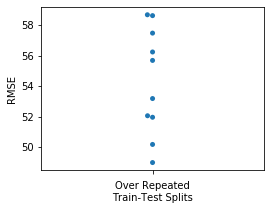

In [22]:
ax = plt.figure(figsize=(4,3)).gca()
sns.swarmplot(y='RMSE', data=df, ax=ax)
ax.set_xlabel('Over Repeated\nTrain-Test Splits');

In [23]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,54.3219,3.5058,49.0032,51.9982,54.4507,57.1823,58.6942


In [24]:
def tts_fit_score(model, data, msr, test_size=.25):
    'data를 훈련-테스트로 분리하고 model를 적합한 다음 msr로 평가합니다.'
    tts = skms.train_test_split(data.data, 
                                data.target, 
                                test_size=test_size)
    
    (train_ftrs, test_ftrs, train_tgt,  test_tgt) = tts
    
    fit   = linreg.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)

    score = msr(test_tgt, preds)
    return score

linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()
scores = [tts_fit_score(linreg, diabetes, 
                       metrics.mean_squared_error) for i in range(10)]
print(np.mean(scores))

3052.540273057884


,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,55.4388,3.5870,50.1900,52.9660,55.3967,58.3911,60.5432


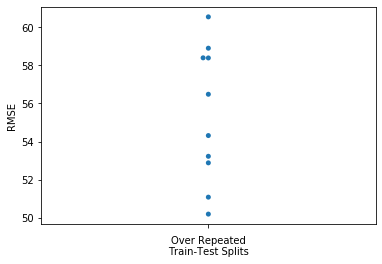

In [25]:
linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

# non-default cv= argument
ss = skms.ShuffleSplit(test_size=.25) # default, 10 splits
scores = skms.cross_val_score(linreg, 
                              diabetes.data, diabetes.target,
                              cv=ss, 
                              scoring='neg_mean_squared_error')

scores = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'

display(df.describe().T)

ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over Repeated\nTrain-Test Splits');

In [26]:
ss = skms.ShuffleSplit(test_size=.25, random_state=42)
train, test = 0,1
next(ss.split(diabetes.data))[train][:10]

array([ 16, 408, 432, 316,   3,  18, 355,  60, 398, 124])

In [27]:
ss = skms.ShuffleSplit(test_size=.25, random_state=42)
next(ss.split(diabetes.data))[train][:10]

array([ 16, 408, 432, 316,   3,  18, 355,  60, 398, 124])

In [28]:
train, test = 0, 1
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [29]:
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [30]:
pet = np.array(['cat', 'dog', 'cat', 
                'dog', 'dog', 'dog'])

kf = skms.KFold(3, shuffle=True)

train, test = 0, 1
split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]

print(split_1_group_1, 
      split_2_group_1)

[0 1 4 5] [0 1 3 5]


In [31]:
kf = skms.KFold(3, shuffle=True, random_state=42)

split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]
print(split_1_group_1, 
      split_2_group_1)

[2 3 4 5] [2 3 4 5]


,count,mean,std,min,25%,50%,75%,max
RMSE,442.0000,44.3557,32.1973,0.2075,18.4820,39.5472,63.9738,158.2355


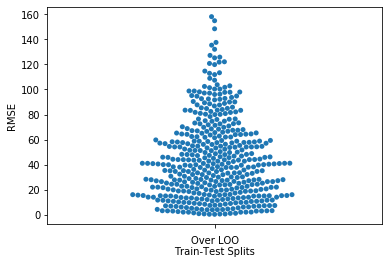

In [32]:
linreg   = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

loo = skms.LeaveOneOut()
scores = skms.cross_val_score(linreg, 
                              diabetes.data, diabetes.target,
                              cv=loo, 
                              scoring='neg_mean_squared_error')

scores = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'

display(df.describe().T)

ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over LOO\nTrain-Test Splits');

In [33]:
iris = datasets.load_iris()

# 10가지 데이터 세트 크기: 10% ~ 100%
# 5폴드 CV로 데이터를 처리
train_sizes = np.linspace(.1,1.0,10)
nn = neighbors.KNeighborsClassifier()

(train_N, 
 train_scores, 
 test_scores) = skms.learning_curve(nn, 
                                    iris.data, iris.target, 
                                    cv=5, 
                                    train_sizes=train_sizes)

# 각 데이터 세트 사이즈별로 5개 CV 점수를 산출
df = pd.DataFrame(test_scores, index=(train_sizes*100).astype(np.int))
df['Mean 5-CV'] = df.mean(axis='columns')
df.index.name = "% Data Used"

display(df)

,0,1,2,3,4,Mean 5-CV
% Data Used,,,,,,
10,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
20,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
30,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
40,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
50,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
60,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
70,0.9000,0.8000,0.8333,0.8667,0.8000,0.8400
80,0.9667,0.9333,0.9000,0.9000,0.9667,0.9333
90,0.9667,1.0000,0.9000,0.9667,1.0000,0.9667


In [34]:
neat_sizes = (train_sizes*100).astype(np.int)
labels = np_cartesian_product(neat_sizes, [0,1], np.arange(5))
score = np.concatenate([train_scores.flatten(), 
                        test_scores.flatten()], axis=0)
assert len(score) == len(labels)

df = pd.DataFrame.from_records(labels)
df.columns = ['pct', 'set', 'fold']
df.set = df.set.replace({0:'Train', 1:'Test'})
df['score'] = score

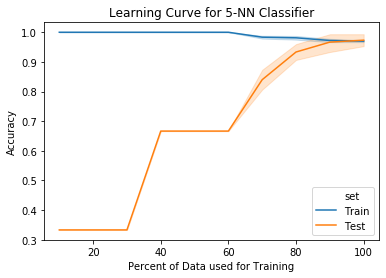

In [35]:
ax = sns.lineplot(x='pct', y='score', hue='set', data=df)

ax.set_title("Learning Curve for 5-NN Classifier")
ax.set_xlabel("Percent of Data used for Training")
ax.set_ylabel("Accuracy");

In [36]:
# seaborn은 더이상 tsplot을 지원하지 않습니다.
# 비교를 위해 코드를 남겨둡니다.
if False:
    joined = np.array([train_scores, test_scores]).transpose()
    ax = sns.tsplot(joined, 
                   time=train_sizes, 
                   condition = ['Train', 'Test'], 
                   interpolate=False)

    ax.set_title("Learning Curve for 5-NN Classifier")
    ax.set_xlabel("Percent of Data used for Training")
    ax.set_ylabel("Accuracy");

In [37]:
num_neigh = [1,3,5,10,15,20]
KNC = neighbors.KNeighborsClassifier
tt = skms.validation_curve(KNC(), 
                           iris.data, iris.target, 
                           param_name='n_neighbors',
                           param_range=num_neigh,
                           cv=5)

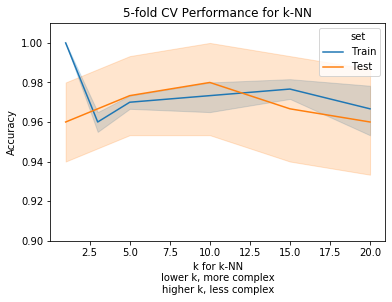

In [38]:
tidy_df = sk_graph_to_tidy(tt, num_neigh, 'k', 5)
ax = sns.lineplot(x='k', y='score', hue='set', data=tidy_df)

ax.set_title('5-fold CV Performance for k-NN')
ax.set_xlabel("\n".join(['k for k-NN',
                         'lower k, more complex',
                         'higher k, less complex']))
ax.set_ylim(.9, 1.01)
ax.set_ylabel('Accuracy');

In [39]:
# tsplot은 더이상 지원하지 않습니다.
# 비교를 위해 코드를 남겨두었습니다. 
if False:
    # tt를 배열로 만들고 전치합니다.
    ax = sns.tsplot(np.array(tt).transpose(), 
                    time=num_neigh, 
                    condition=['Train', 'Test'], 
                    interpolate=False)

    ax.set_title('5-fold CV Performance for k-NN')
    ax.set_xlabel("\n".join(['k for k-NN',
                             'lower k, more complex',
                             'higher k, less complex']))
    ax.set_ylim(.9, 1.01)
    ax.set_ylabel('Accuracy');

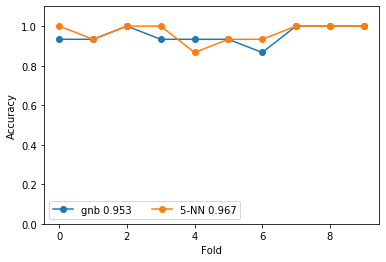

In [40]:
classifiers = {'gnb' : naive_bayes.GaussianNB(),
               '5-NN' : neighbors.KNeighborsClassifier(n_neighbors=5)}

iris = datasets.load_iris()

fig, ax = plt.subplots(figsize=(6,4))
for name, model in classifiers.items():
    cv_scores = skms.cross_val_score(model, 
                                     iris.data, iris.target, 
                                     cv=10, 
                                     scoring='accuracy', 
                                     n_jobs=-1) # 코어를 모두 사용합니다.
    my_lbl = "{} {:.3f}".format(name, cv_scores.mean())
    ax.plot(cv_scores, '-o', label=my_lbl)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend(ncol=2);